# Robots.txt in top-10k domains

See the [data preparation notebook](./data-preparation.ipynb) for data collection.



In [1]:
# read directive statistics

import pandas as pd

df_counts = pd.read_csv('data/robotsstats-cc-main.txt', sep='\t')
df_counts['year'] = df_counts['crawl'].str[0:4]


In [2]:
df_counts[df_counts['directive'] == 'user-agent'][['year', 'value', 'count']].head()

,year,value,count
3,2016,*,7428
47,2016,Googlebot,421
49,2016,Mediapartners-Google,375
51,2016,Twitterbot,251
53,2016,Slurp,243


In [3]:
# read ranks and rule sets

from collections import defaultdict
try:
    import ujson as json
except ImportError:
    import json

import tldextract

ranks = pd.read_csv('data/cc-main-2022-may-jun-aug-domain-ranks-top-10k.txt', sep='\t', names=['rank', 'rev-domain'])
def reverse_domain(d):
    parts = d.split('.')
    parts.reverse()
    return '.'.join(parts)
ranks['domain'] = ranks['rev-domain'].apply(reverse_domain)
ranks.set_index('domain', inplace=True)

crawls = ['2016-36', '2017-34', '2018-34', '2019-35', '2020-34', '2021-39', '2022-33']
rulesets = defaultdict(lambda: defaultdict(list))
for crawl in crawls:
    with open('data/rulesets/cc-main-{}.jsonl'.format(crawl)) as s:
        for line in s:
            obj = json.loads(line)
            for host_name in obj:
                domain = tldextract.extract(host_name).registered_domain
                rulesets[crawl][domain] = obj[host_name]

rulesets = pd.DataFrame(rulesets).merge(ranks, how='right', left_index=True, right_index=True)
rulesets.head()

,2016-36,2017-34,2018-34,2019-35,2020-34,2021-39,2022-33,rank,rev-domain
domain,,,,,,,,,
googleapis.com,{'*': {'allow': ['/']}},{'*': {'allow': ['/']}},{'*': {'allow': ['/']}},{'*': {'allow': ['/']}},{'*': {'allow': ['/']}},NaN,NaN,1,com.googleapis
facebook.com,"{'*': {'disallow': ['/']}, 'Applebot': {'allow...","{'*': {'disallow': ['/']}, 'Applebot': {'allow...","{'*': {'disallow': ['/']}, 'Applebot': {'allow...","{'*': {'disallow': ['/']}, 'Applebot': {'allow...","{'*': {'disallow': ['/']}, 'Applebot': {'allow...","{'*': {'disallow': ['/']}, 'Applebot': {'allow...","{'*': {'disallow': ['/']}, 'Applebot': {'allow...",2,com.facebook
google.com,"{'*': {'allow': ['/?gws_rd=ssl$', '/?hl=', '/?...","{'*': {'allow': ['/?gws_rd=ssl$', '/?hl=', '/?...","{'*': {'allow': ['/?gws_rd=ssl$', '/?hl=', '/?...","{'*': {'allow': ['/?gws_rd=ssl$', '/?hl=', '/?...","{'*': {'allow': ['/?gws_rd=ssl$', '/?hl=', '/?...","{'*': {'allow': ['/?gws_rd=ssl$', '/?hl=', '/?...","{'*': {'allow': ['/?gws_rd=ssl$', '/?hl=', '/?...",3,com.google
twitter.com,{'*': {'disallow': ['/']}},{'*': {'disallow': ['/']}},{'*': {'disallow': ['/']}},{'*': {'disallow': ['/']}},{'*': {'disallow': ['/']}},{'*': {'disallow': ['/']}},"{'*': {'allow': ['/*?lang=', '/hashtag/*?src='...",4,com.twitter
youtube.com,"{'*': {'disallow': ['/comment', '/get_video', ...","{'*': {'disallow': ['/channel/*/community', '/...","{'*': {'disallow': ['/channel/*/community', '/...","{'*': {'disallow': ['/channel/*/community', '/...","{'*': {'disallow': ['/channel/*/community', '/...","{'*': {'disallow': ['/channel/*/community', '/...","{'*': {'disallow': ['/channel/*/community', '/...",5,com.youtube


## Usage of robots.txt on web sites

In [4]:
# percentage of top 10k domains with robots.txt crawled
usage_stats = pd.DataFrame()
usage_stats.index.rename('crawl', inplace=True)
usage_stats['found'] = (~rulesets[crawls].isna()).sum()
usage_stats['% found'] = 100.0 * (usage_stats['found'] / rulesets.shape[0])

In [5]:
# ... and also successfully parsed and rules found
import math

usage_stats['withrules'] = (~rulesets[crawls].applymap(lambda c: math.isnan(c) if isinstance(c, float) else len(c) == 0)).sum()
usage_stats['% withrules'] = 100.0 * (usage_stats['withrules'] / rulesets.shape[0])
usage_stats['year'] = usage_stats.index.str[0:4]
usage_stats

,found,% found,withrules,% withrules,year
crawl,,,,,
2016-36,7221,72.21,6754,67.54,2016
2017-34,7156,71.56,6699,66.99,2017
2018-34,7521,75.21,7034,70.34,2018
2019-35,7594,75.94,7120,71.20,2019
2020-34,7658,76.58,7189,71.89,2020
2021-39,7677,76.77,7232,72.32,2021
2022-33,7588,75.88,7161,71.61,2022


- more robots.txt capture missing for prior years (but that's expected because the domain list is from 2022)
- in recent years there is a robots.txt files for at least 70% of the 10,000 domains
  - other sites may have not be visited by the crawler
  - did return a 404 or other errors when requesting `/robots.txt`
  - or the robots.txt failed to parse (consequently, no rules found)

## User-agents addressed



In [6]:
# trial 1
# - abandoned because counts are slightly too high
# - the data counts the number of occurrences
#   but one robots.txt may contain the same user-agent
#   line multiple times

df = df_counts[df_counts['directive'] == 'user-agent']

# get most frequently addressed user-agents
min_count = 200 # min. 2% share in one of crawls

top_user_agents = set(df[df['count'] > min_count]['value'].to_list())
top_user_agents

{'*',
 'AdsBot-Google',
 'AhrefsBot',
 'Baiduspider',
 'Googlebot',
 'MJ12bot',
 'Mediapartners-Google',
 'SemrushBot',
 'Slurp',
 'Swiftbot',
 'Twitterbot',
 'Yandex',
 'bingbot',
 'ia_archiver'}

In [7]:
df = df[df['value'].isin(top_user_agents)]
df['%'] = df['count'] / 100.0 # per 10k domains
df

,crawl,directive,value,count,year,%
3,2016-36,user-agent,*,7428,2016,74.28
47,2016-36,user-agent,Googlebot,421,2016,4.21
49,2016-36,user-agent,Mediapartners-Google,375,2016,3.75
51,2016-36,user-agent,Twitterbot,251,2016,2.51
53,2016-36,user-agent,Slurp,243,2016,2.43
...,...,...,...,...,...,...
1138644,2022-33,user-agent,AdsBot-Google,211,2022,2.11
1138650,2022-33,user-agent,Slurp,203,2022,2.03
1138651,2022-33,user-agent,Baiduspider,201,2022,2.01
1138652,2022-33,user-agent,ia_archiver,196,2022,1.96


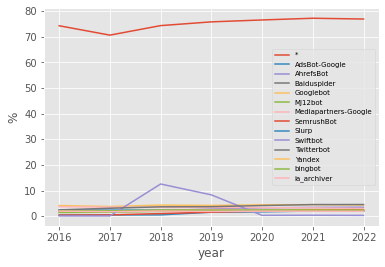

In [8]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

pivot = df[['year', 'value', '%']].pivot(index='year', columns='value', values='%')
axes = pivot.plot(ylabel='%')
axes.legend(fontsize=7)
plt.savefig('img/user-agent-share.svg')

<AxesSubplot:xlabel='year', ylabel='count'>

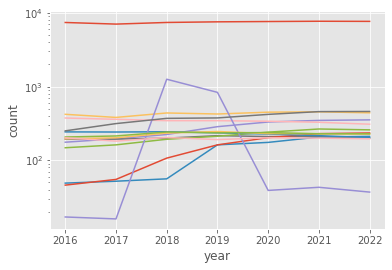

In [9]:
pivot = df[['year', 'value', 'count']].pivot(index='year', columns='value', values='count')
pivot.plot(kind='line', logy=True, legend=False, ylabel='count')

In [10]:
# trial 2
from collections import Counter

user_agent_counts = []
for crawl in crawls:
    counts = Counter()
    for ruleset in rulesets[crawl].to_list():
        if isinstance(ruleset, dict):
            for ua in ruleset:
                counts[ua.lower()] += 1    
    for ua in counts:
        user_agent_counts.append([crawl, ua, counts[ua]])
    # all parseable robots.txt files
    user_agent_counts.append([crawl, '(any)', usage_stats.loc[crawl, 'withrules']])

user_agent_counts = pd.DataFrame(user_agent_counts, columns=['crawl', 'value', 'count'])
user_agent_counts.head()

,crawl,value,count
0,2016-36,*,6632
1,2016-36,applebot,32
2,2016-36,bingbot,173
3,2016-36,googlebot,430
4,2016-36,naverbot,31


In [11]:
user_agent_counts['year'] = user_agent_counts['crawl'].str[0:4]
user_agent_counts['%'] = user_agent_counts['count'] / 100.0 # per 10k domains
df = user_agent_counts

min_count = 150
top_user_agents = set(df[df['count'] > min_count]['value'].to_list())
top_user_agents

{'(any)',
 '*',
 'adsbot-google',
 'ahrefsbot',
 'baiduspider',
 'bingbot',
 'dotbot',
 'googlebot',
 'googlebot-image',
 'googlebot-news',
 'ia_archiver',
 'mediapartners-google',
 'mj12bot',
 'msnbot',
 'semrushbot',
 'slurp',
 'twitterbot',
 'yandex'}

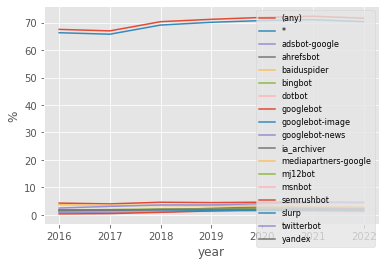

In [12]:
df = df[df['value'].isin(top_user_agents)]

pivot = df[['year', 'value', '%']].pivot(index='year', columns='value', values='%')
axes = pivot.plot(ylabel='%')
axes.legend(fontsize=8)
plt.savefig('img/user-agent-share.svg')

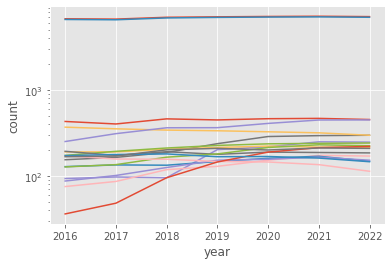

In [13]:
pivot = df[['year', 'value', 'count']].pivot(index='year', columns='value', values='count')
pivot.plot(kind='line', logy=True, legend=False, ylabel='count')
plt.savefig('img/user-agent-share-logscale.svg')

In [14]:
years_select = map(lambda s: s[0:4], crawls)

ua_agent_share_by_year = df[df['year'].isin(years_select)][['value', 'year', 'count']].set_index('value').pivot(columns='year', values='count')
ua_agent_share_by_year.index.rename('user-agent', inplace=True)
ua_agent_share_by_year.sort_values(['2022'], ascending=False, inplace=True)
ua_agent_share_by_year

year,2016,2017,2018,2019,2020,2021,2022
user-agent,,,,,,,
(any),6754,6699,7034,7120,7189,7232,7161
*,6632,6578,6911,7012,7075,7107,7034
googlebot,430,402,461,448,463,467,453
twitterbot,251,310,363,364,408,447,448
mediapartners-google,369,353,341,335,326,317,297
ahrefsbot,154,164,187,237,287,294,297
adsbot-google,93,97,95,202,218,249,247
bingbot,173,193,211,226,236,239,241
mj12bot,127,135,165,180,214,230,224


In [15]:
# LaTeX table export
#print(ua_agent_share_by_year.to_latex())

## Robots.txt favorizing or penalizing user agents



In [16]:
# 

crawl = '2022-33' # crawl looked at
target_user_agents = [*filter(lambda x: x != '(any)', top_user_agents),
                      'applebot', 'neevabot', 'applebot (googlebot)', 'neevabot (googlebot)',
                      'seznambot', 'petalbot', 'ccbot']
max_rank = 10000

def classify(rules):
    # allow_all, disallow_all, allow-part
    if rules == {'disallow': ['/']}:
        return 'disallow-all'
    if (rules == {'allow': ['/']} or rules == {'allow': ['*']}
        or rules == {'allow': ['/*']} or rules == {'allow': ['']}
        or rules == {'disallow': ['']}):
        return 'allow-all'
    return 'allow-part'

stat = defaultdict(Counter)
domains_preferring_ua = defaultdict(list)
domains_penalizing_ua = defaultdict(list)

for domain, rows in rulesets.iterrows():
    ruleset = rows[crawl]
    rank = rows['rank']
    tmp = defaultdict()
    for tua in target_user_agents:
        if not isinstance(ruleset, dict):
            tmp[tua] = 'unknown'
            continue
        for ua in ruleset:
            if ua.lower() == tua:
                tmp[tua] = classify(ruleset[ua])
                stat['addressed'][tua] += 1
    for tua in target_user_agents:
        if tua in tmp:
            stat[tmp[tua]][tua] += 1
            continue
        if tua in ['applebot (googlebot)', 'neevabot (googlebot)']:
            # count when using Googlebot as fall-back pays off
            tua_real = tua[0:8]
            if tua_real in tmp:
                stat[tmp[tua_real]][tua] += 1
                stat['addressed'][tua] += 1
                continue 
            if 'googlebot' in tmp:
                stat[tmp['googlebot']][tua] += 1
                continue
        if '*' in tmp:
            # have fall-back user-agent
            stat[tmp['*']][tua] += 1
        else:
            stat['allow-all'][tua] += 1
    wildcard = 'allow-all'
    if '*' in tmp:
        wildcard = tmp['*']
    for tua in target_user_agents:
        if tua in tmp:
            if wildcard == 'disallow-all' and tmp[tua] != 'disallow-all':
                domains_preferring_ua[tua].append((domain, rank))
            elif tmp[tua] == 'disallow-all' and wildcard != 'disallow-all':
                domains_penalizing_ua[tua].append((domain, rank))
    if rank > max_rank:
        break

df = pd.DataFrame(stat)
df['score'] = df['allow-all'] + .5 * df['allow-part'] - df['disallow-all']
df.sort_values(['score'], ascending=False, inplace=True)
del(df['score'])
del(df['unknown'])
df

,addressed,allow-part,disallow-all,allow-all
twitterbot,448,6018,58,1512
mediapartners-google,297,5967,74,1547
googlebot,453,6191,38,1359
neevabot (googlebot),2,6190,39,1359
applebot (googlebot),46,6193,43,1352
bingbot,241,6174,55,1359
adsbot-google,247,6106,75,1407
msnbot,113,6148,65,1375
googlebot-news,152,6142,74,1372
googlebot-image,148,6113,82,1393


In [17]:
# LaTeX table export
#print(df.to_latex())

In [18]:
ua_queried = 'twitterbot'
print('preferred', domains_preferring_ua[ua_queried])
print('penalized', domains_penalizing_ua[ua_queried])

preferred [('facebook.com', 2), ('instagram.com', 7), ('fb.com', 77), ('trustpilot.com', 635), ('mailchi.mp', 742), ('thejakartapost.com', 749), ('smugmug.com', 1080), ('iframe.ly', 1372), ('cargocollective.com', 1754), ('missingkids.org', 1865), ('cuny.edu', 1972), ('campaign-archive.com', 2209), ('nextdoor.com', 3713), ('puu.sh', 3944), ('usgbc.org', 4318), ('sharechat.com', 4552), ('amsterdam.nl', 5438), ('ouest-france.fr', 6160), ('gm.com', 6870), ('hubblesite.org', 6997), ('courtlistener.com', 8349), ('mk.co.kr', 8447)]
penalized [('fourmilab.ch', 6114), ('aithority.com', 9510)]


## Lenghs of rules

How many allow/disallow statements are there addressing a single user-agent (or the wildcard user-agent)? How complex are rules?

In [19]:
# count number of rules per rule block (addressing one user-agent)

crawl = '2022-33'

length_counts = Counter()
lengths = []

for domain, rows in rulesets.iterrows():
    ruleset = rows[crawl]
    if not isinstance(ruleset, dict):
        continue
    for ua in ruleset:
        rules = ruleset[ua]
        cls = classify(rules)
        if cls == 'disallow-all':
            # count "disallow: /" separately (as length -1)
            length_counts[-1] += 1
            lengths.append(1)
        elif cls == 'allow-all':
            # count "allow: /" separately (as length 0)
            length_counts[0] += 1
            lengths.append(1)
        else:
            length = 0
            for allow_disallow in rules:
                length += len(rules[allow_disallow])
            length_counts[length] += 1
            lengths.append(length)
            #if length > 500:
            #    print(domain, len(rules))

df = pd.DataFrame([[k, v] for k,v in length_counts.items()], columns=['length', 'count'])

bins = [-2, -1, 0, 1, 2, 4, 9, 19, 49, 99, 199, 499, 999, 50000] #200, 500, 1000, 2000, 5000, 10000, 20000, 
cats = ['1 (disallow: /)', '1 (allow: /)', '1', '2', '2-4', '5-9', '10-19', '20-49', '50-99', '100-199', '200-499', '500-999', '1000-']
df['length_bins'] = pd.cut(df['length'], bins, labels=cats)
df['length_bins'] = pd.Categorical(df['length_bins'], ordered=True, categories=cats)

histo = df[['length_bins', 'count']].groupby('length_bins').sum()
histo

,count
length_bins,
1 (disallow: /),19800
1 (allow: /),2049
1,1310
2,1358
2-4,969
5-9,1481
10-19,1433
20-49,1567
50-99,784


In [20]:
# LaTeX table export
#print(histo.to_latex())

<AxesSubplot:xlabel='length_bins'>

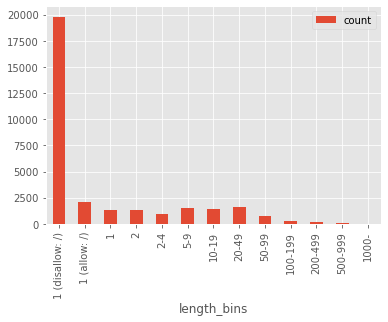

In [21]:
histo.plot(kind='bar')